In this assignment we will generate an ensemble of primitive classifiers, using Bagging
method, and compare their performances to the regular classifiers.

This week’s problem is the classification of heart failure disease. Download the Kaggle
heart.csv dataset file from the module content. Load the dataset into your model development
framework and examine the features to note that they are a mixture of numerical and nominal
features. Apply necessary pre-processing such as nominal to numerical conversions (e.g.
OneHotEncoder). Make sure to sanity check the pipeline and perhaps run your favorite baseline
classifier first.

In [1]:
# Environment setup
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# Locate and load the data files
df_raw = pd.read_csv('../../Desktop/APML/Datasets/heart_dataset.csv')
df_raw.info()
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
# Checking for duplicates - adapted from Guven, 2024.
df_raw["is_duplicate"]= df_raw.duplicated()
print(f"#duplicated= {len(df_raw[df_raw['is_duplicate']==True])}")

# Drop the duplicate rows using index - best way to drop in pandas
index_to_drop = df_raw[df_raw['is_duplicate']==True].index
df_raw.drop(index_to_drop, inplace=True)

print('--------')
print(f"Duplicated cases:")
# Remove the duplicate marker column
df_raw.drop(columns='is_duplicate', inplace=True)
print(f'#total unique cases= {len(df_raw)}')

# Check missing values in each column
print('--------')
print(f"Number of missing values in columns:")
p0 = df_raw.isnull().sum()
print(p0)

#duplicated= 0
--------
Duplicated cases:
#total unique cases= 918
--------
Number of missing values in columns:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [4]:
# Check unique levels and see any marker is used for a missing level
for col in df_raw.columns:
    if df_raw[col].dtype == object:
        print(col, df_raw[col].unique())

Sex ['M' 'F']
ChestPainType ['ATA' 'NAP' 'ASY' 'TA']
RestingECG ['Normal' 'ST' 'LVH']
ExerciseAngina ['N' 'Y']
ST_Slope ['Up' 'Flat' 'Down']


### EDA

In [5]:
# Identify the nominal and numerical features
nominal_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

# Basic statistical details
df_raw.describe(include = 'all')

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918.000000,918,918,918.000000,918.000000,918.000000,918,918.000000,918,918.000000,918,918.000000
unique,NaN,2,4,NaN,NaN,NaN,3,NaN,2,NaN,3,NaN
top,NaN,M,ASY,NaN,NaN,NaN,Normal,NaN,N,NaN,Flat,NaN
freq,NaN,725,496,NaN,NaN,NaN,552,NaN,547,NaN,460,NaN
mean,53.510893,NaN,NaN,132.396514,198.799564,0.233115,NaN,136.809368,NaN,0.887364,NaN,0.553377
std,9.432617,NaN,NaN,18.514154,109.384145,0.423046,NaN,25.460334,NaN,1.066570,NaN,0.497414
min,28.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,60.000000,NaN,-2.600000,NaN,0.000000
25%,47.000000,NaN,NaN,120.000000,173.250000,0.000000,NaN,120.000000,NaN,0.000000,NaN,0.000000
50%,54.000000,NaN,NaN,130.000000,223.000000,0.000000,NaN,138.000000,NaN,0.600000,NaN,1.000000
75%,60.000000,NaN,NaN,140.000000,267.000000,0.000000,NaN,156.000000,NaN,1.500000,NaN,1.000000


/var/folders/8c/f79_3ppx1r59rycv6tkm4flh0000gn/T/ipykernel_27978/3679206536.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_raw.corr(), annot=True) # , fmt=".2f")


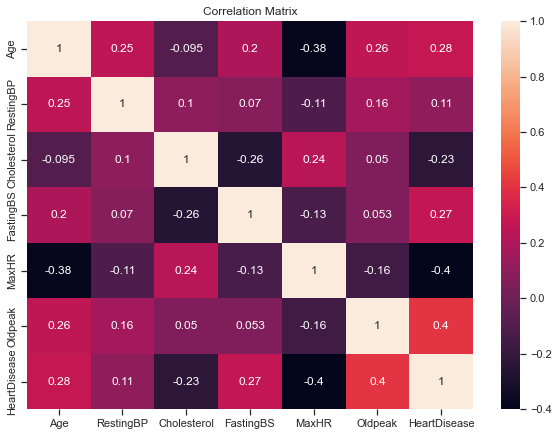

In [6]:
# Heatmap of correlation matrix
plt.figure(figsize=(10, 7))
sns.heatmap(df_raw.corr(), annot=True) # , fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

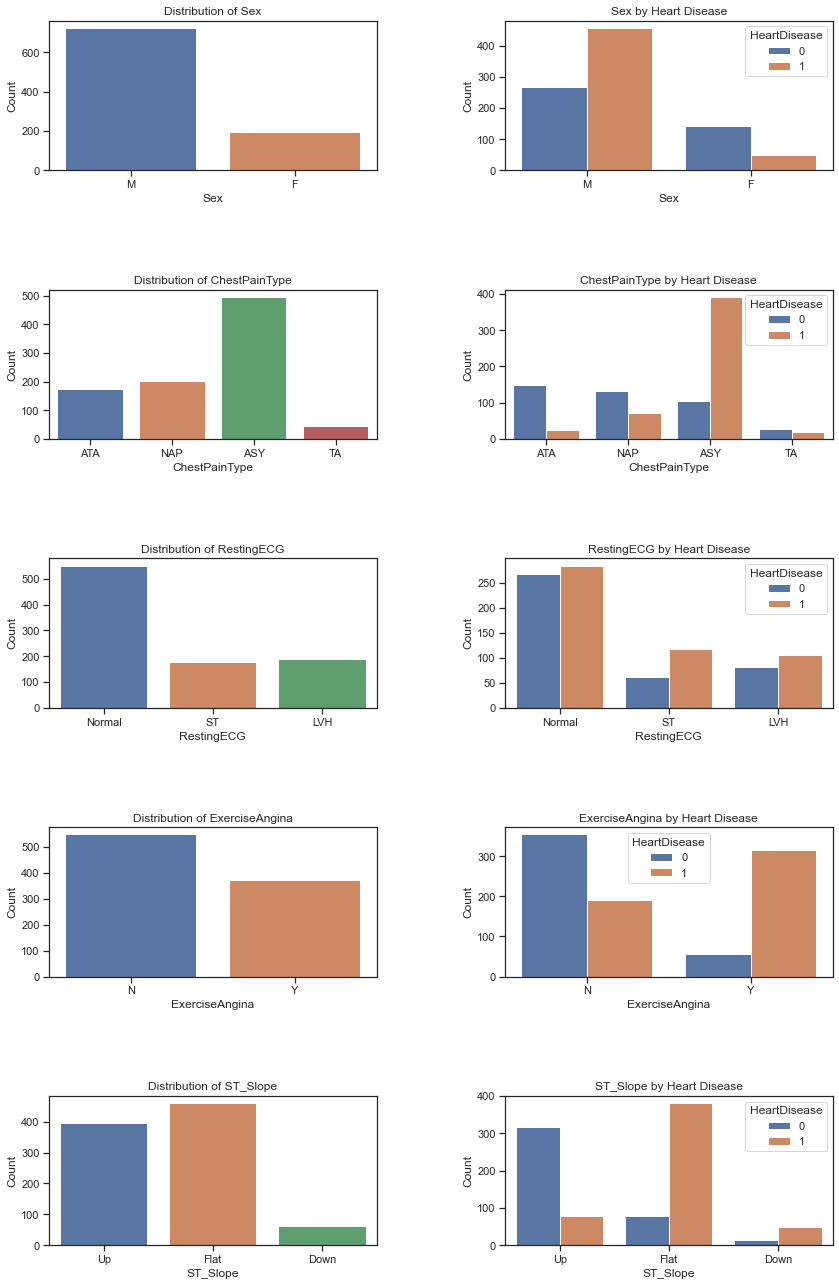

In [7]:
# Create a figure to hold the subplots
fig, axes = plt.subplots(nrows=len(nominal_features), ncols=2, figsize=(14, len(nominal_features) * 4))
fig.tight_layout(pad=8.0)

for i, var in enumerate(nominal_features):
    # Value counts bar plot for each categorical variable
    sns.countplot(x=var, data=df_raw, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {var}')
    axes[i, 0].set_ylabel('Count')

    # Count plot showing the distribution of categories with respect to the target variable
    sns.countplot(x=var, hue='HeartDisease', data=df_raw, ax=axes[i, 1])
    axes[i, 1].set_title(f'{var} by Heart Disease')
    axes[i, 1].set_ylabel('Count')

plt.show()

In [8]:
# Checking the balance of the target variable
target_balance = df_raw['HeartDisease'].value_counts(normalize=True)  # Get the proportion of each class

print("Category balance")
target_balance

Category balance


1    0.553377
0    0.446623
Name: HeartDisease, dtype: float64

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

heart_data = df_raw.copy()

# Split the dataset into features (X) and target variable (y)
X = heart_data.drop('HeartDisease', axis=1)
y = heart_data['HeartDisease']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

# Define the pre-processing for nominal features
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), ['ChestPainType', 'RestingECG', 'ST_Slope']),
        ('ordinal', OrdinalEncoder(), ['Sex', 'ExerciseAngina'])
    ],
    remainder='passthrough'  # Keep the numerical features unchanged
)

# Create a pipeline with the preprocessor and a RandomForestClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model's accuracy
rf_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {rf_accuracy:.4f}')

(734, 11) (184, 11)
Accuracy: 0.8641


In [10]:
# # Fit and transform the training data using the preprocessor
# X_train_preprocessed = preprocessor.fit_transform(X_train)

# # Get feature names after one-hot encoding
# feature_names = (
#     preprocessor.named_transformers_['onehot'].get_feature_names_out(['ChestPainType', 'RestingECG', 'ST_Slope']).tolist() +
#     ['Sex', 'ExerciseAngina'] +  # Binary features (after ordinal encoding)
#     [name for name in X_train.columns if name not in ['ChestPainType', 'RestingECG', 'ST_Slope', 'Sex', 'ExerciseAngina']]  # Numerical features
# )

# # Convert the transformed data into a DataFrame
# X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names)

# X_train_preprocessed_df.head()

1. [10 pts] Report 10-fold cross-validation (“CV”) performances of the following types of
classifiers, using default parameters:
- GaussianNB
- Linear SVC (use SVC(kernel='linear', probability=True))
- MLPClassifier
- DecisionTreeClassifier

Now report the RandomForestClassifier performance too. Since this is already an
ensemble classifier, this one does not need to be done with CV.

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# Function to evaluate a classifier using 10-fold cross-validation - from Guven, 2024
def eval_classifier(_clf, _X, _y):
    accuracies = []
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(_X, _y):
        _clf.fit(_X[train_index], _y[train_index])
        y_pred = _clf.predict(_X[test_index])
        accuracies.append(accuracy_score(_y[test_index], y_pred))
    return np.array(accuracies)

# Define classifiers
classifiers = {
    "GaussianNB": GaussianNB(),
    "Linear SVC": SVC(kernel='linear', probability=True),
    "MLPClassifier": MLPClassifier(max_iter=500),  # Increased max_iter for convergence
    "DecisionTreeClassifier": DecisionTreeClassifier(),
}

# Preprocess the dataset
X_preprocessed = preprocessor.fit_transform(X)  # Using the preprocessor defined earlier
y_np = y 

# Evaluate classifiers using 10-fold CV
cv_results = {}
for name, clf in classifiers.items():
    accuracies = eval_classifier(clf, X_preprocessed, y_np)
    cv_results[name] = {"Mean Accuracy": np.mean(accuracies), "Std Dev": np.std(accuracies)}

cv_results

{'GaussianNB': {'Mean Accuracy': 0.8561992355470617,
  'Std Dev': 0.03262489993589096},
 'Linear SVC': {'Mean Accuracy': 0.8703296703296702,
  'Std Dev': 0.03224142963588389},
 'MLPClassifier': {'Mean Accuracy': 0.8442307692307691,
  'Std Dev': 0.04403583304721313},
 'DecisionTreeClassifier': {'Mean Accuracy': 0.7853559483994267,
  'Std Dev': 0.045101053116368514}}

In [12]:
# Redefine and train RandomForestClassifier on the training set
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model's accuracy
rf_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {rf_accuracy:.4f}')

Accuracy: 0.8641


2. [10 pts] Generate an ensemble of 100 classifiers for each of the four basic classifiers in Q1.
and store each ensemble as a list. In order to create weak sub-classifiers within our
ensembles, we underpower some hyperparameters:

- For the neural network, set the hidden sizes to (3, 3), max iterations to 30, and tolerance to 1e-1.
-  For the decision tree, set max depth to 5 and max features to 5.

For each of these 4 ensembles, report the performance of the first classifier in the
ensemble. I.e., for your ensemble of 100 decision trees, report the performance of just the
first weak tree.

In [13]:
%%time

from sklearn.base import clone

# Define the base classifiers with specified hyperparameters
base_classifiers = {
    "GaussianNB": GaussianNB(),
    "Linear SVC": SVC(kernel='linear', probability=True),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(3, 3), max_iter=30, tol=1e-1),
    "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=5, max_features=5),
}

# Initialize ensembles as lists of 100 classifier instances
ensembles = {name: [clone(clf) for _ in range(100)] for name, clf in base_classifiers.items()}
from sklearn.model_selection import train_test_split

# Split the preprocessed data into training and testing sets
X_train_preprocessed, X_test_preprocessed, y_train_np, y_test_np = train_test_split(
    X_preprocessed, y_np, test_size=0.2, random_state=42
)

# Train the first classifier of each ensemble and evaluate its performance on the correct test set
first_classifier_performance = {}
for name, ensemble in ensembles.items():
    first_clf = ensemble[0]  # Get the first classifier from the ensemble
    first_clf.fit(X_train_preprocessed, y_train_np)  # Train on the preprocessed training set
    y_pred = first_clf.predict(X_test_preprocessed)  # Predict on the preprocessed test set
    accuracy = accuracy_score(y_test_np, y_pred)  # Evaluate accuracy using the correct test labels
    first_classifier_performance[name] = accuracy

first_classifier_performance

CPU times: user 8.6 s, sys: 559 ms, total: 9.16 s
Wall time: 8.48 s


/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


{'GaussianNB': 0.8586956521739131,
 'Linear SVC': 0.8532608695652174,
 'MLPClassifier': 0.44021739130434784,
 'DecisionTreeClassifier': 0.8478260869565217}

These results show how each "weak" classifier performs individually. The MLPClassifier, with its underpowered hyperparameters, shows notably lower performance, which is expected given the constraints placed on its complexity. In an ensemble approach, the goal is to combine many such "weak" classifiers to achieve better overall performance.

3. [20 pts] Write a function ensemble_fit() to receive the ensemble (i.e. one of the 4 lists from
Q2.) as an input and train it on one of the subsets (i.e. bagging) of the training data. (Hint:
random.sample could generate the subset of data you’ll need.) This way, each classifier will
see only a different subset of the training dataset, also called as subsampling the input data
for training. Use all features in these subsamples; only subsample the rows/observations.

In [15]:
import random

def ensemble_fit(ensemble, X_train, y_train, subset_size=0.8):
    """
    Trains each classifier in the ensemble on a different subset of the training data.
    ensuring that each subset contains at least one instance of every class.
    
    Parameters:
    - ensemble: list of classifiers
    - X_train: training features
    - y_train: training labels (as a NumPy array to support positional indexing)
    - subset_size: fraction of the training set to use for each classifier (default: 0.8)
    
    The function modifies the classifiers in place, so it doesn't return anything.
    """
    n_samples = int(len(X_train) * subset_size)
    y_train_np = y_train.to_numpy()  # Convert to NumPy array for positional indexing
    
    for clf in ensemble:
        while True:
            # Generate random indices for the subset
            indices = random.sample(range(len(X_train)), n_samples)

            # Select the subset of the training data
            X_train_subset = X_train[indices]
            y_train_subset = y_train_np[indices]

        # Check if the subset contains at least one instance of every class
            if len(np.unique(y_train_subset)) > 1:
                # If yes, break the loop and train the classifier on the subset
                clf.fit(X_train_subset, y_train_subset)
                break
            # If not, continue the loop and resample

# # Example of training the GaussianNB ensemble
# ensemble_fit(ensembles['GaussianNB'], X_train_preprocessed, y_train_np)
# # Indicate that the function has been executed and the ensemble has been trained
# "Ensemble 'GaussianNB' has been trained."

4. [20 pts] Write a function ensemble_predict() to receive the trained ensemble (i.e. one of
the lists from Q3.) as input and output a prediction for a given observation. Since each sub-
classifier will have its own prediction, use a voting scheme on the returned predictions.
(Hint: The final prediction should be the np.argmax() of the votes, not merely a “max”. Note
that c.predict_proba() should have better results.)


In [17]:
def ensemble_predict(ensemble, observations):
    """
    Predicts the class for given observations using a trained ensemble of classifiers.
    
    Parameters:
    - ensemble: list of trained classifiers
    - observations: array-like, shape (n_samples, n_features)
    
    Returns:
    - predictions: array, shape (n_samples,)
      The predicted class for each observation.
    """
    # Initialize an array to store the sum of predicted probabilities from all classifiers
    sum_of_probabilities = None

    for clf in ensemble:
        # Get predicted probabilities for the current classifier
        probabilities = clf.predict_proba(observations)
        
        # Ensure two-column format for binary classification probabilities
        if probabilities.shape[1] == 1:
            # Convert single-column probabilities to two-column format
            probabilities = np.hstack([1 - probabilities, probabilities])

        # Initialize the sum_of_probabilities array with the correct shape, if it's the first iteration
        if sum_of_probabilities is None:
            sum_of_probabilities = np.zeros_like(probabilities)

        # Add the predicted probabilities to the sum
        sum_of_probabilities += probabilities

    # The final prediction is the class with the highest probability after aggregating all predictions
    predictions = np.argmax(sum_of_probabilities, axis=1)

    return predictions

# # Using the provided ensemble_predict function with the GaussianNB ensemble on the first 5 test observations
# sample_predictions = ensemble_predict(ensembles['GaussianNB'], X_test_preprocessed[:5])
# sample_predictions

5. [20 pts] Report 10-fold CV performances of the ensembles with a subsample ratio of 0.2.
Compare to a regular decision tree (same subsample ratio). Now repeat these for a
subsample ratio of 0.05.

In [18]:
def cv_ensemble_performance(ensemble, X, y, subset_size, n_splits=10):
    """
    Evaluates the ensemble performance using 10-fold cross-validation and specified subset size for training.
    
    Parameters:
    - ensemble: list of classifiers to be trained as an ensemble
    - X: Full set of features
    - y: Full set of labels
    - subset_size: fraction of the training set to use for training each classifier in the ensemble
    - n_splits: Number of folds in cross-validation
    
    Returns:
    - Mean accuracy and standard deviation across the folds
    """
    accuracies = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train the ensemble on a subset of the training data
        ensemble_fit(ensemble, X_train, y_train, subset_size)
        
        # Predict and evaluate
        y_pred = ensemble_predict(ensemble, X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    
    return np.mean(accuracies), np.std(accuracies)

In [19]:
%%time
# Initialize a single Decision Tree classifier for comparison
dt_classifier = DecisionTreeClassifier()

# Evaluate ensembles and the Decision Tree classifier with a subsample ratio of 0.2
ensemble_results_02 = {}
for name, ensemble in ensembles.items():
    reduced_ensemble = [clone(clf) for clf in ensemble]  # Use only 5 classifiers in the ensemble for quicker computation
    mean_acc, std_dev = cv_ensemble_performance(reduced_ensemble, X_preprocessed, y_np, subset_size=0.2, n_splits=10)
    ensemble_results_02[name] = {"Mean Accuracy": mean_acc, "Std Dev": std_dev}

# Evaluate the Decision Tree classifier with a subsample ratio of 0.2 using the same CV process
dt_cloned = clone(dt_classifier)  # Clone the Decision Tree for isolation
dt_mean_acc_02, dt_std_dev_02 = cv_ensemble_performance([dt_cloned], X_preprocessed, y_np, subset_size=0.2, n_splits=10)
dt_results_02 = {"Mean Accuracy": dt_mean_acc_02, "Std Dev": dt_std_dev_02}

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

CPU times: user 23min 58s, sys: 2.87 s, total: 24min 1s
Wall time: 43min 32s


In [20]:
print("Ensemble Results (Subsample ratio = 0.2)")
for name, metrics in ensemble_results_02.items():
    print(f"{name}: {metrics['Mean Accuracy']:.4f} ± {metrics['Std Dev']:.4f}")

print(f"Decision Tree Results (Subsample ratio = 0.2) Accuracy: {dt_results_02['Mean Accuracy']:.4f} ± {dt_results_02['Std Dev']:.4f}")

Ensemble Results (Subsample ratio = 0.2)
GaussianNB: 0.8562 ± 0.0288
Linear SVC: 0.8682 ± 0.0251
MLPClassifier: 0.5414 ± 0.0715
DecisionTreeClassifier: 0.8681 ± 0.0384
Decision Tree Results (Subsample ratio = 0.2) Accuracy: 0.7788 ± 0.0481


In [21]:
%%time

ensemble_results_005 = {}
for name, ensemble in ensembles.items():
    reduced_ensemble = [clone(clf) for clf in ensemble]  # Continue using a reduced number of classifiers for quicker computation
    mean_acc, std_dev = cv_ensemble_performance(reduced_ensemble, X_preprocessed, y_np, subset_size=0.05)  # Changed subset_size to 0.05
    ensemble_results_005[name] = {"Mean Accuracy": mean_acc, "Std Dev": std_dev}

# Evaluate the Decision Tree classifier with a subsample ratio of 0.05 using the same CV process
dt_cloned_005 = clone(dt_classifier)  # Clone the Decision Tree for isolation
dt_mean_acc_005, dt_std_dev_005 = cv_ensemble_performance([dt_cloned_005], X_preprocessed, y_np, subset_size=0.05)  # Changed subset_size to 0.05
dt_results_005 = {"Mean Accuracy": dt_mean_acc_005, "Std Dev": dt_std_dev_005}

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

CPU times: user 2min 29s, sys: 590 ms, total: 2min 29s
Wall time: 36min 45s


In [22]:
print("Ensemble Results (Subsample ratio = 0.05)")
for name, metrics in ensemble_results_005.items():
    print(f"{name}: {metrics['Mean Accuracy']:.4f} ± {metrics['Std Dev']:.4f}")

print(f"Decision Tree Results (Subsample ratio = 0.05) Accuracy: {dt_results_005['Mean Accuracy']:.4f} ± {dt_results_005['Std Dev']:.4f}")

Ensemble Results (Subsample ratio = 0.05)
GaussianNB: 0.8562 ± 0.0267
Linear SVC: 0.8594 ± 0.0376
MLPClassifier: 0.5327 ± 0.0571
DecisionTreeClassifier: 0.8693 ± 0.0381
Decision Tree Results (Subsample ratio = 0.05) Accuracy: 0.7288 ± 0.0629


6. [10 pts] Report the 10-fold CV performances of the ensembles for the training subsample
ratios of (0.005, 0.01, 0.03, 0.05, 0.1, 0.2). Now train regular versions of those 4 classifiers
and report their performance. (Hint: pass the regular classifier to the same ensemble CV in
a list of one element. This way, the same script can be used for this entire step).

In [24]:
def ensemble_predict(ensemble, observations):
    """
    Predicts the class for given observations using a trained ensemble of classifiers.
    
    Parameters:
    - ensemble: list of trained classifiers
    - observations: array-like, shape (n_samples, n_features)
    
    Returns:
    - predictions: array, shape (n_samples,)
      The predicted class for each observation.
    """
    # Initialize an array to store the sum of predicted probabilities from all classifiers
    sum_of_probabilities = None

    for clf in ensemble:
        # Get predicted probabilities for the current classifier
        probabilities = clf.predict_proba(observations)
        
        # Ensure two-column format for binary classification probabilities
        if probabilities.shape[1] == 1:
            # Convert single-column probabilities to two-column format
            probabilities = np.hstack([1 - probabilities, probabilities])

        # Initialize the sum_of_probabilities array with the correct shape, if it's the first iteration
        if sum_of_probabilities is None:
            sum_of_probabilities = np.zeros_like(probabilities)

        # Add the predicted probabilities to the sum
        sum_of_probabilities += probabilities

    # The final prediction is the class with the highest probability after aggregating all predictions
    predictions = np.argmax(sum_of_probabilities, axis=1)

    return predictions

def evaluate_classifiers_and_ensembles(ensembles, base_classifiers, X, y, subsample_ratios, n_splits=10):
    """
    Evaluates ensembles and base classifiers using cross-validation for specified subsample ratios.
    
    Parameters:
    - ensembles: Dictionary of ensemble classifiers.
    - base_classifiers: Dictionary of base classifier instances.
    - X: Full set of features.
    - y: Full set of labels.
    - subsample_ratios: List of subsample ratios to evaluate.
    - n_splits: Number of folds in cross-validation.
    
    Returns:
    - Dictionary of evaluation results for each subsample ratio, classifier, and ensemble.
    """
    results = {ratio: {} for ratio in subsample_ratios}

    for ratio in subsample_ratios:
        # Evaluate ensembles
        for name, ensemble in ensembles.items():
            mean_acc, std_dev = cv_ensemble_performance(ensemble, X, y, ratio, n_splits)
            results[ratio][f'Ensemble {name}'] = {"Mean Accuracy": mean_acc, "Std Dev": std_dev}

        # Evaluate base classifiers
        for name, clf in base_classifiers.items():
            mean_acc, std_dev = cv_ensemble_performance([clone(clf)], X, y, ratio, n_splits)  # Single-element list for consistency
            results[ratio][f'Regular {name}'] = {"Mean Accuracy": mean_acc, "Std Dev": std_dev}

    return results

In [27]:
%%time

# Define base classifiers for comparison
base_classifiers = {
    "GaussianNB": GaussianNB(),
    "Linear SVC": SVC(kernel='linear', probability=True),
    "MLPClassifier": MLPClassifier(max_iter=500),  # Increased max_iter for convergence
    "DecisionTreeClassifier": DecisionTreeClassifier(),
}

# Subsample ratios to evaluate
subsample_ratios = [0.005, 0.01, 0.03, 0.05, 0.1, 0.2]

# Evaluate ensembles and base classifiers for each subsample ratio
evaluation_results = evaluate_classifiers_and_ensembles(ensembles, base_classifiers, X_preprocessed, y_np, subsample_ratios)

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/User

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/k

/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kavyabanerjee/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


CPU times: user 38min 25s, sys: 13.5 s, total: 38min 38s
Wall time: 38min 37s


7. [10 pts] For each of the 4 types of classifier, plot the performances of the ensemble at the
different subsample ratios and the performances of the regular classifier at the different
subsample ratios on the same plot. Thus, you should have 4 plots, one for each type of
classifier. To make it graphically clear which performances are ensemble vs. regular,
plotting in 2 different colors is recommended.
Report your detailed observations.

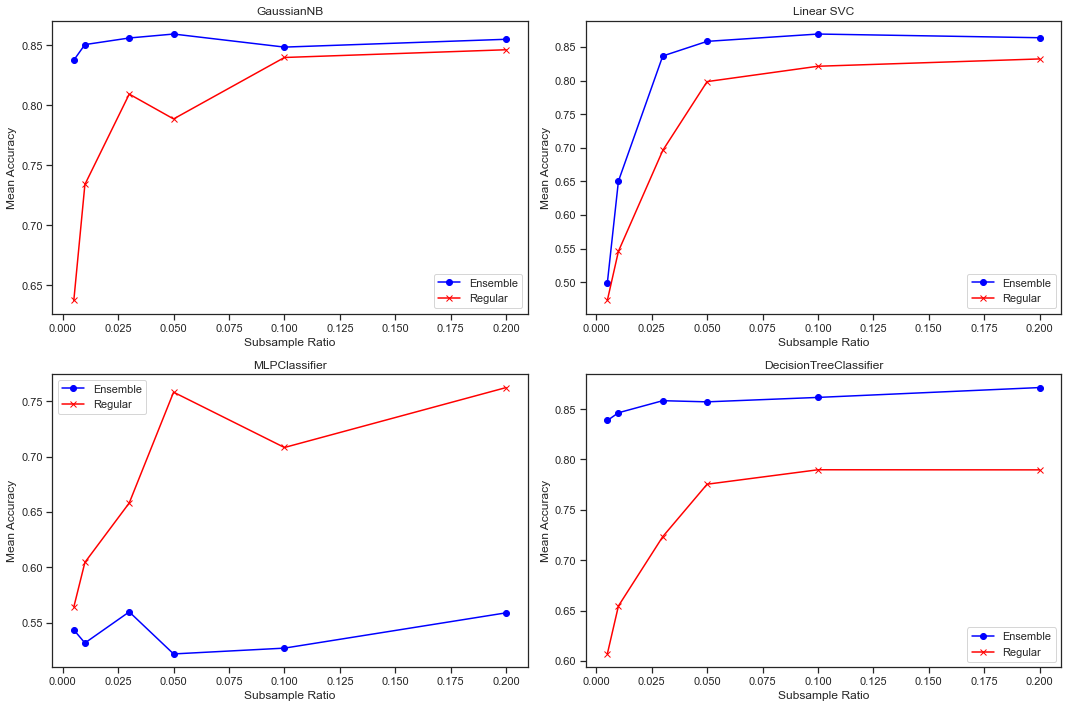

In [28]:
# Subsample ratios 
subsample_ratios = [0.005, 0.01, 0.03, 0.05, 0.1, 0.2]

# Classifier names
classifier_names = ["GaussianNB", "Linear SVC", "MLPClassifier", "DecisionTreeClassifier"]

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, classifier_name in enumerate(classifier_names):
    ensemble_accuracies = []
    regular_accuracies = []
    
    for ratio in subsample_ratios:
        # Extract ensemble and regular classifier accuracies for the current classifier and subsample ratio
        ensemble_accuracy = evaluation_results[ratio][f'Ensemble {classifier_name}']['Mean Accuracy']
        regular_accuracy = evaluation_results[ratio][f'Regular {classifier_name}']['Mean Accuracy']
        
        ensemble_accuracies.append(ensemble_accuracy)
        regular_accuracies.append(regular_accuracy)

    # Plotting the performances for the current classifier
    ax = axes[i]
    ax.plot(subsample_ratios, ensemble_accuracies, label='Ensemble', marker='o', color='blue')
    ax.plot(subsample_ratios, regular_accuracies, label='Regular', marker='x', color='red')
    ax.set_title(classifier_name)
    ax.set_xlabel('Subsample Ratio')
    ax.set_ylabel('Mean Accuracy')
    ax.legend()

plt.tight_layout()
plt.show()

Note: Observations based on 1 run, average runs not performed due to hardware limitations.

- The observations across different classifiers (GaussianNB, Linear SVC, and DecisionTreeClassifier) in relation to ensemble and regular classifiers against various subsample ratios highlights the superior performance of ensemble classifiers, particularly at lower subsample ratios. For GaussianNB and Linear SVC, the ensemble classifiers exhibit high and stable or steeply increasing performance at very low subsample ratios, significantly outperforming their regular counterparts until the subsample ratio increases to a certain point where regular classifiers catch up. In the case of the DecisionTreeClassifier, the ensemble maintains a consistently high performance across all subsample ratios, whereas the regular classifier improves with more data but never matches the ensemble's performance. 

- The ensemble of MLPClassifiers underperforms compared to the regular MLPClassifier across all subsample ratios, as shown in the provided graph. The ensemble's performance decreases from an accuracy of approximately 0.55 to just over 0.50 with increasing data, whereas the regular classifier's performance improves markedly from below 0.60 to about 0.80 accuracy. This underperformance of the ensemble could be attributed to overly restrictive hyperparameters for the ensemble's weak learners, insufficient diversity in the training data subsets due to the subsampling strategy, ineffective methods for integrating predictions from individual ensemble members, and possibly the complex nature of MLPs, which may not suit the ensemble approach used.

- The performance of regular classifiers improves with an increased subsample ratio indicates that they benefit from seeing more data, but the ensemble classifiers (except the MLPClassifiers) start strong and remain consistently high-performing regardless of the subsample size, which showcases their strength in this particular task.